# Confidence Simulations with Pilot Responses 10% Hazard

1. Read in data from PilotData4 (hazard rate 10%; survey)
2. Simulate confidences:
    1. Normative
    2. ~~Restricted normative (using subject's window)~~
    3. Normative + 20% noise
    4. ~~Restricted normative + 20% noise~~
    5. Random
3. Compute I_past, I_future for task only, task + confidence, confidence only (maybe start with one subject)
4. Compare differences/ratios of I_past for different confidence simulations
5. Compare differences/ratios of I_future for different confidence simulations

In [375]:
import importlib
#importlib.reload(sm)

<module 'smfile' from '/Users/vwang/Documents/PennMed/Gold Lab/Preregistration/Urn-Confidence/Pilot/smfile.py'>

In [414]:
import pandas as pd
import numpy as np
from embo import InformationBottleneck
import HMM_beads_utils as ut
import smfile as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
import adjustText
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [415]:
D = pd.read_csv("PilotData4_munged.csv", dtype = {'History': str})

In [416]:
D['Subject'].unique()
D

array(['5ebd', '5e9d', '5da7', '60ce', '5f52', '60c8'], dtype=object)

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011
5996,60c8,1006,0,0,1,0,0,01101110110
5997,60c8,1007,0,0,0,0,1,01011101100
5998,60c8,1008,0,0,0,0,1,00111011000


In [417]:
for sub in D['Subject'].unique():
    subD = D[D['Subject'] == sub].reset_index()
    normative = sm.gen_sim_pred(sub,subD['Bead'],subD['Jar'],subD['Trial'],p = 0.8,h = 0.1)
    D.loc[D['Subject'] == sub, 'Prior'] = normative['Prior'].values
    #D.loc[D['Subject'] == sub, 'Posterior'] = normative['Posterior'].values
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [418]:
D_n = D.copy()
D_s = D.copy()
D_r = D.copy()

D_n['Confidence'] = D_n.groupby(['Subject'], group_keys=False).apply(lambda g: abs(0.5 - g.Prior) > abs(0.5 - g.Prior).median())*1
D_s['Confidence'] = sm.add_noise(D_n['Confidence'],0.1)
D_r['Confidence'] = sm.add_noise(D_n['Confidence'],0.5)

Ddict = {'orig': D, 'normative': D_n, 'normslop': D_s, 'random': D_r}

In [419]:
D['Subject'].unique()[3]

'60ce'

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

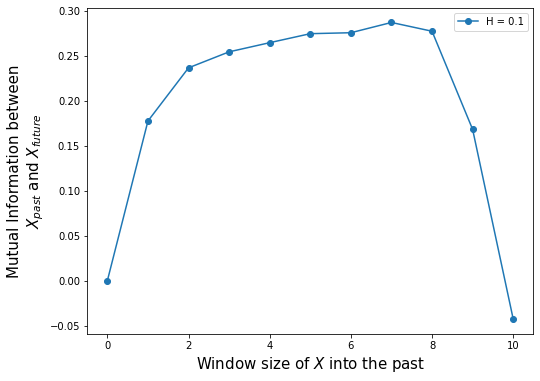

In [420]:
maxw = 10

bound_seq = D[D['Subject'] == D['Subject'].unique()[3]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Low confidence')

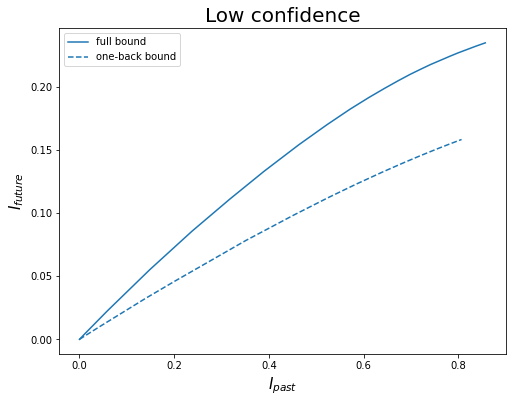

In [421]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

In [422]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [423]:
I_window = []

def window_helper(i_p, i_f, dname, includes):
    m = []
    for sub in i_p.keys():
        df = pd.DataFrame({
            'Subject':sub,
            'sim':dname,
            'includes':includes,
            'window':np.arange(len(i_p[sub])),
            'Ip':i_p[sub],
            'If':i_f[sub]
        })
        m.extend(df.values)
    return(m)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    I_window.extend(window_helper(ip_task, if_task, dname, "task"))
    I_window.extend(window_helper(ip_conf, if_conf, dname, "conf"))
    I_window.extend(window_helper(ip_both, if_both, dname, "both"))

I_window_df = pd.DataFrame(I_window, columns = ['Subject', 'sim', 'includes', 'window', 'Ip', "If"])
I_window_df

,Subject,sim,includes,window,Ip,If
0,5ebd,orig,task,0,0.000000,0.151968
1,5ebd,orig,task,1,0.390080,0.151968
2,5ebd,orig,task,2,0.608519,0.151968
3,5ebd,orig,task,3,0.639487,0.151968
4,5ebd,orig,task,4,0.679021,0.151968
...,...,...,...,...,...,...
499,60c8,random,both,2,0.560938,0.153649
500,60c8,random,both,3,0.614282,0.153649
501,60c8,random,both,4,0.622907,0.153649
502,60c8,random,both,5,0.611100,0.153649


In [424]:
nboot = 10
Ip_boot = []
If_boot = []

def boot_helper(ip_boot, dname, includes):
    df = pd.DataFrame({
        'Subject':ip_boot.keys(),
        'sim':dname,
        'includes':includes,
        'mean':np.array([np.mean(ip_boot[key]) for key in ip_boot.keys()]),
        '95CI':np.array([np.std(ip_boot[key])*1.96 for key in ip_boot.keys()])
    })
    return(df)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    ip_task_boot, if_task_boot = sm.get_bootstrapped_samples(d,ip_task,nboot)
    ip_conf_boot, if_conf_boot = sm.get_bootstrapped_samples_confo(d,ip_conf,nboot)
    ip_both_boot, if_both_boot = sm.get_bootstrapped_samples_confid(d,ip_both,nboot)
    
    Ip_boot.extend(boot_helper(ip_task_boot, dname, "task").values)
    Ip_boot.extend(boot_helper(ip_conf_boot, dname, "conf").values)
    Ip_boot.extend(boot_helper(ip_both_boot, dname, "both").values)
    If_boot.extend(boot_helper(if_task_boot, dname, "task").values)
    If_boot.extend(boot_helper(if_conf_boot, dname, "conf").values)
    If_boot.extend(boot_helper(if_both_boot, dname, "both").values)

Ip_boot_df = pd.DataFrame(Ip_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])
If_boot_df = pd.DataFrame(If_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])

In [425]:
Ip_boot_df
If_boot_df

,Subject,sim,includes,mean,95CI
0,5ebd,orig,task,0.742822,0.047006
1,5e9d,orig,task,0.622545,0.039491
2,5da7,orig,task,0.718464,0.046993
3,60ce,orig,task,0.919761,0.019819
4,5f52,orig,task,0.737586,0.039430
...,...,...,...,...,...
67,5e9d,random,both,0.670174,0.032957
68,5da7,random,both,0.855271,0.056287
69,60ce,random,both,1.006597,0.019132
70,5f52,random,both,0.818111,0.058178


,Subject,sim,includes,mean,95CI
0,5ebd,orig,task,0.151205,0.038073
1,5e9d,orig,task,0.108039,0.061531
2,5da7,orig,task,0.185746,0.045133
3,60ce,orig,task,0.217707,0.043703
4,5f52,orig,task,0.163118,0.037526
...,...,...,...,...,...
67,5e9d,random,both,0.099014,0.026113
68,5da7,random,both,0.176220,0.054607
69,60ce,random,both,0.230789,0.045765
70,5f52,random,both,0.173295,0.035068


In [426]:
I_window_df['includes'].unique()

array(['task', 'conf', 'both'], dtype=object)

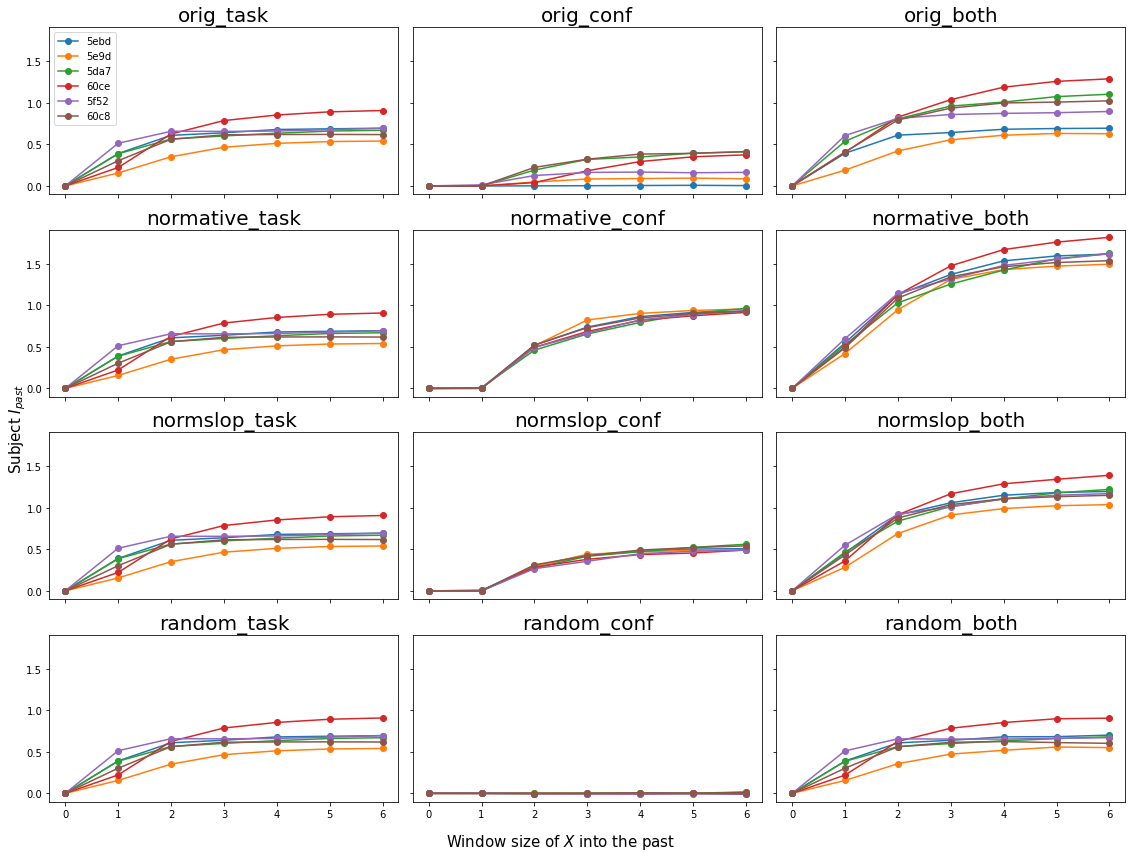

In [427]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            axs[i,j].plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        axs[i,j].set_title(sim + "_" + includes,size=20)
axs[0,0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

In [429]:
boot_data_full = pd.merge(Ip_boot_df,If_boot_df, on = ['Subject','sim','includes'], suffixes = ['_ip', '_if'])

In [430]:
#colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
colors = dict(zip(set(Ip_boot_df['includes'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['includes'].unique()))]))

boot_data_full['color'] = boot_data_full['includes'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['sim']

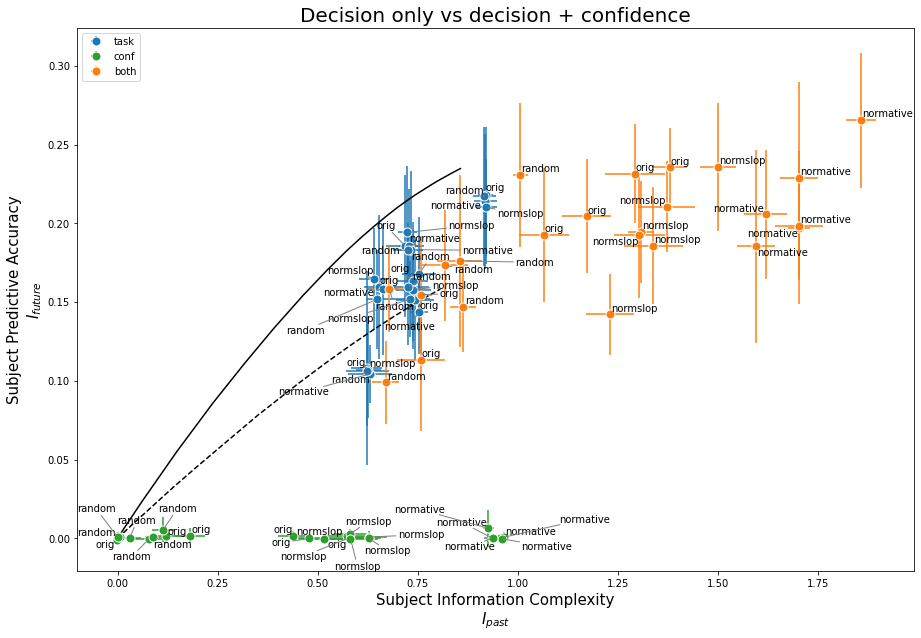

In [431]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
boot_data = boot_data_full#[boot_data_full['Subject'] == boot_data_full['Subject'].unique()[2]]

fig = plt.figure(1,(15,10))
ax = fig.add_subplot(111)
r,p=spearmanr(Ip_boot_df['mean'],If_boot_df['mean'])
ax.plot(ip_fullbound,if_fullbound,'-k')
ax.plot(ip_1backbound,if_1backbound,'--k')
texts = []
for index,row in boot_data.iterrows():
    ax.errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
             marker='o',markersize=9,mec='white',color=row['color'],ls='none', label = row['includes'])
    texts.append(ax.text(row['mean_ip'],row['mean_if'],row['label'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys(), loc = "upper left")
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
plt.show;

In [432]:
colors

{'task': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'both': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'conf': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}

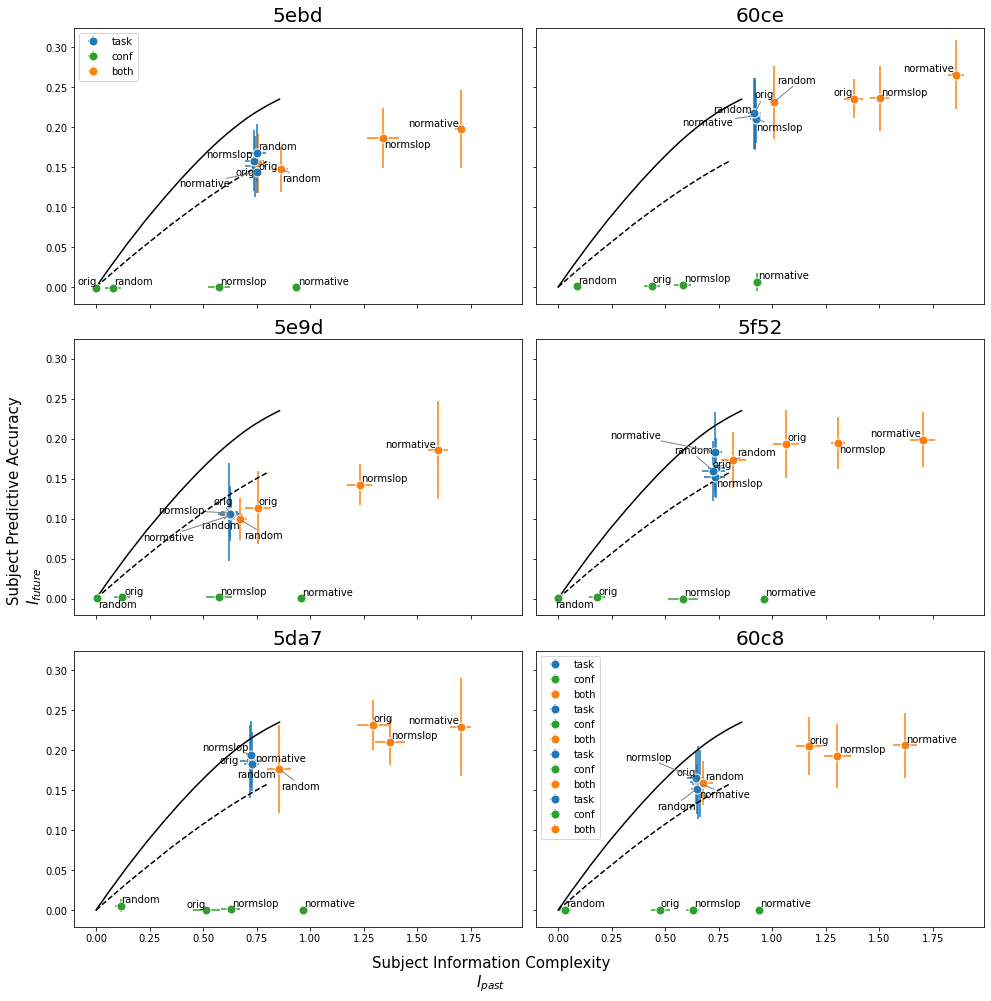

In [433]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14), sharex = True, sharey = True)
texts = [[] for i in np.arange(len(boot_data_full['Subject'].unique()))] 
for i,sub in enumerate(boot_data_full['Subject'].unique()):
    boot_data = boot_data_full[boot_data_full['Subject'] == sub]
    axs[i%3,int(i/3)].plot(ip_fullbound,if_fullbound,'-k')
    axs[i%3,int(i/3)].plot(ip_1backbound,if_1backbound,'--k')
    for index,row in boot_data.iterrows():
        axs[i%3,int(i/3)].errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
                 marker='o',markersize=9,mec='white',color=row['color'],ls='none',label=row['includes'])
        texts[i].append(axs[i%3,int(i/3)].text(row['mean_ip'],row['mean_if'],row['label']))
    adjust_text(texts[i], ax = axs[i%3,int(i/3)],arrowprops=dict(arrowstyle="-",color='grey'))
    axs[i%3,int(i/3)].set_title(sub,size=20)
#    axs[i%3,int(i/3)].text(0, 0.15, r'$\frac{Ip_{conf}}{Ip_{task} = }$' + 
#                boot_data[(boot_data['includes'] == "conf") & (boot_data['sim'] == orig)]/boot_data[(boot_data['includes'] == "conf") & (boot_data['sim'] == orig)], fontsize=15)
fig.supylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
fig.supxlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.legend(loc = "upper left")
#fig.suptitle('Decision only vs decision + confidence',size=20)
axs[0,0].legend()
handles, labels = axs[0,0].get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
axs[0,0].legend(lgd.values(), lgd.keys(),loc = 'upper left')
plt.tight_layout()
plt.show;

In [434]:
melted_boot = boot_data_full[['Subject', 'sim', 'includes', 'mean_ip', 'mean_if']]\
.melt(id_vars = ['Subject', 'sim', 'includes'])\
.assign(variable = lambda g: [i.split("_")[1] for i in g.variable])\
.rename(columns={"value": "mean"})

In [435]:
Ipast_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "ip")]\
.rename(columns={"mean":"Ipast_task"})
Ifuture_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "if")]\
.rename(columns={"mean":"Ifuture_task"})
#melted_boot.merge(melted_boot[['Subject']])

In [436]:
melted_boot

,Subject,sim,includes,variable,mean
0,5ebd,orig,task,ip,0.742822
1,5e9d,orig,task,ip,0.622545
2,5da7,orig,task,ip,0.718464
3,60ce,orig,task,ip,0.919761
4,5f52,orig,task,ip,0.737586
...,...,...,...,...,...
139,5e9d,random,both,if,0.099014
140,5da7,random,both,if,0.176220
141,60ce,random,both,if,0.230789
142,5f52,random,both,if,0.173295


In [437]:
melted_boot['mean'][9] + melted_boot['mean'][10]

0.6197617776036068

In [438]:
C = D[D['Subject'] == "60ce"].copy().reset_index(drop = True)
C = C.assign(Response = 1 * (C['Prior'] > 0.5))
C = C.assign(Confidence = (abs(0.5 - C['Prior']) > abs(0.5 - C['Prior']).median())*1)

In [439]:
C

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,60ce,10,1,1,0,0,0,01111111110,0.500000
1,60ce,11,0,0,1,0,0,01111111101,0.740000
2,60ce,12,0,0,0,0,1,01111111010,0.432584
3,60ce,13,0,0,0,0,1,01111110100,0.228067
4,60ce,14,0,0,0,1,1,01111101000,0.155025
...,...,...,...,...,...,...,...,...,...
995,60ce,1005,1,1,0,0,0,00000000001,0.396663
996,60ce,1006,1,0,1,0,0,00000000011,0.679602
997,60ce,1007,1,1,0,0,1,00000000110,0.377219
998,60ce,1008,1,1,1,0,1,00000001101,0.666274


In [440]:
C_both = C.copy()
C_confid = C.assign(Response = sm.add_noise(C['Response'],0.5))
C_task = C.assign(Confidence = sm.add_noise(C['Confidence'],0.5))
C_none = C.assign(Confidence = sm.add_noise(C['Confidence'],0.5), Response = sm.add_noise(C['Response'],0.5))
Ddict = {'none': C_none, 'task': C_task, 'confid': C_confid, 'both': C_both}

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

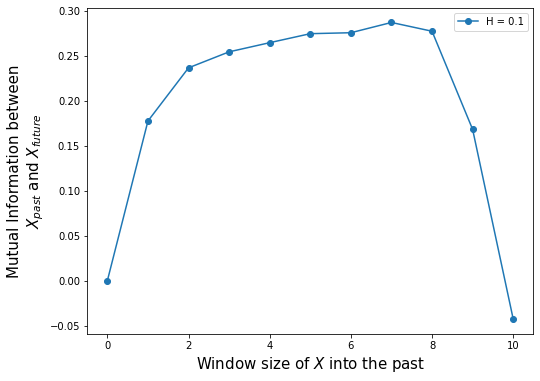

In [441]:
maxw = 10

bound_seq = D[D['Subject'] == D['Subject'].unique()[3]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Low confidence')

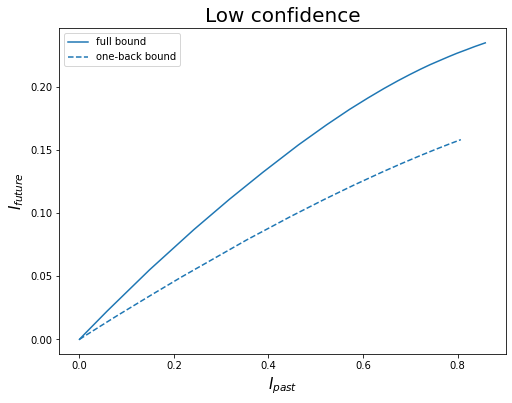

In [442]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

In [443]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [444]:
I_window = []

def window_helper(i_p, i_f, dname, includes):
    m = []
    for sub in i_p.keys():
        df = pd.DataFrame({
            'Subject':sub,
            'sim':dname,
            'includes':includes,
            'window':np.arange(len(i_p[sub])),
            'Ip':i_p[sub],
            'If':i_f[sub]
        })
        m.extend(df.values)
    return(m)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    I_window.extend(window_helper(ip_task, if_task, dname, "task"))
    I_window.extend(window_helper(ip_conf, if_conf, dname, "conf"))
    I_window.extend(window_helper(ip_both, if_both, dname, "both"))

I_window_df = pd.DataFrame(I_window, columns = ['Subject', 'sim', 'includes', 'window', 'Ip', "If"])
I_window_df

,Subject,sim,includes,window,Ip,If
0,60ce,none,task,0,0.000000,0.000022
1,60ce,none,task,1,-0.000354,0.000022
2,60ce,none,task,2,0.000138,0.000022
3,60ce,none,task,3,-0.000068,0.000022
4,60ce,none,task,4,-0.003270,0.000022
...,...,...,...,...,...,...
79,60ce,both,both,2,1.141726,0.247111
80,60ce,both,both,3,1.537683,0.247111
81,60ce,both,both,4,1.752856,0.247111
82,60ce,both,both,5,1.846139,0.247111


In [445]:
nboot = 10
Ip_boot = []
If_boot = []

def boot_helper(ip_boot, dname, includes):
    df = pd.DataFrame({
        'Subject':ip_boot.keys(),
        'sim':dname,
        'includes':includes,
        'mean':np.array([np.mean(ip_boot[key]) for key in ip_boot.keys()]),
        '95CI':np.array([np.std(ip_boot[key])*1.96 for key in ip_boot.keys()])
    })
    return(df)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    ip_task_boot, if_task_boot = sm.get_bootstrapped_samples(d,ip_task,nboot)
    ip_conf_boot, if_conf_boot = sm.get_bootstrapped_samples_confo(d,ip_conf,nboot)
    ip_both_boot, if_both_boot = sm.get_bootstrapped_samples_confid(d,ip_both,nboot)
    
    Ip_boot.extend(boot_helper(ip_task_boot, dname, "task").values)
    Ip_boot.extend(boot_helper(ip_conf_boot, dname, "conf").values)
    Ip_boot.extend(boot_helper(ip_both_boot, dname, "both").values)
    If_boot.extend(boot_helper(if_task_boot, dname, "task").values)
    If_boot.extend(boot_helper(if_conf_boot, dname, "conf").values)
    If_boot.extend(boot_helper(if_both_boot, dname, "both").values)

Ip_boot_df = pd.DataFrame(Ip_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])
If_boot_df = pd.DataFrame(If_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])

In [446]:
Ip_boot_df
If_boot_df

,Subject,sim,includes,mean,95CI
0,60ce,none,task,0.005064,0.012453
1,60ce,none,conf,0.007521,0.012315
2,60ce,none,both,0.024553,0.018544
3,60ce,task,task,0.967711,0.005946
4,60ce,task,conf,0.016212,0.014542
5,60ce,task,both,1.011106,0.023235
6,60ce,confid,task,0.000327,0.002676
7,60ce,confid,conf,0.926424,0.012778
8,60ce,confid,both,0.989204,0.039255
9,60ce,both,task,0.970851,0.011925


,Subject,sim,includes,mean,95CI
0,60ce,none,task,0.000356,0.001826
1,60ce,none,conf,0.000260,0.001494
2,60ce,none,both,-0.000897,0.001988
3,60ce,task,task,0.215338,0.028389
4,60ce,task,conf,0.001392,0.002641
5,60ce,task,both,0.225558,0.038229
6,60ce,confid,task,0.000500,0.001912
7,60ce,confid,conf,0.005835,0.007210
8,60ce,confid,both,0.005685,0.007506
9,60ce,both,task,0.218988,0.044910


In [447]:
I_window_df['includes'].unique()

array(['task', 'conf', 'both'], dtype=object)

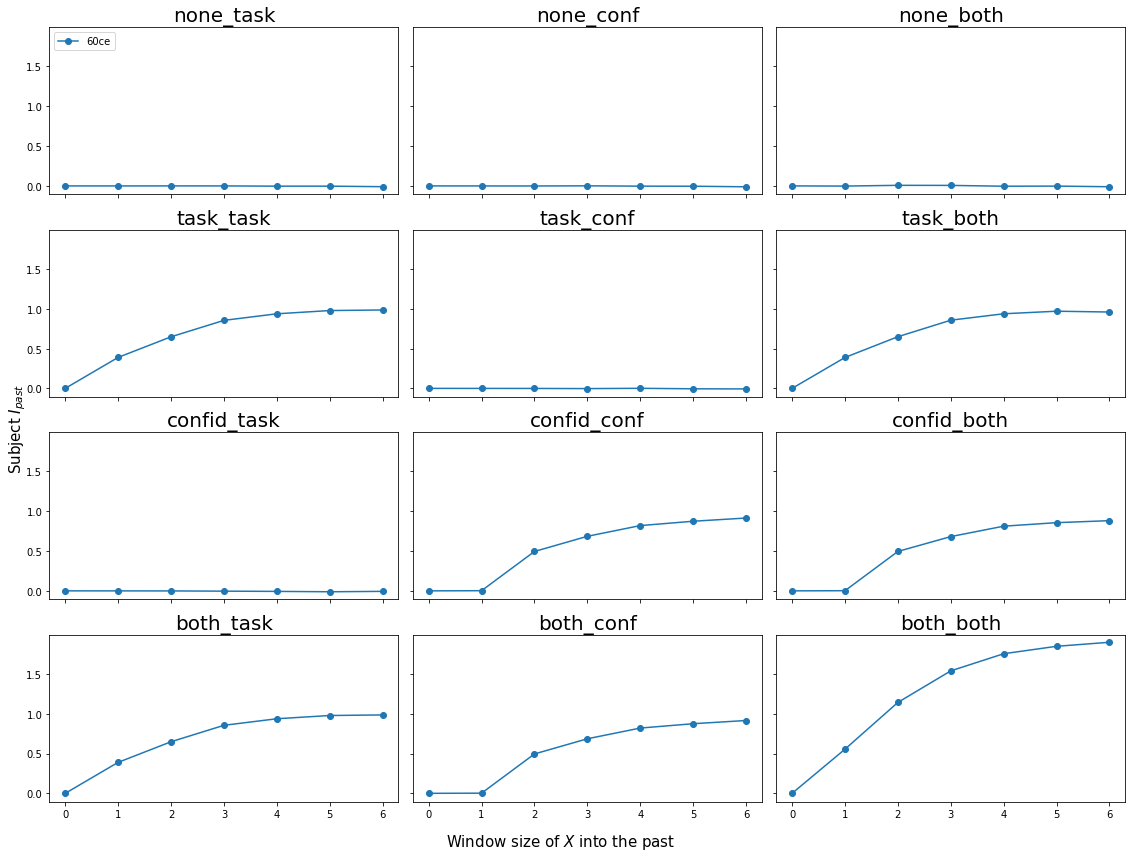

In [448]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            axs[i,j].plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        axs[i,j].set_title(sim + "_" + includes,size=20)
axs[0,0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

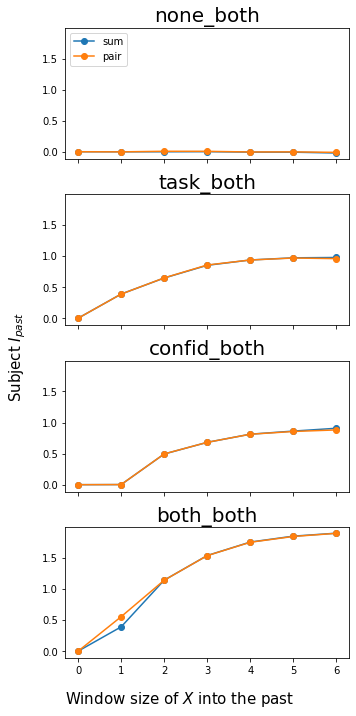

In [449]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 10), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    includes = "both"
    Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
    for sub in Itype['Subject'].unique():
        Isub = Itype[Itype['Subject'] == sub]
        axs[i].plot(Isub['window'],[sum(i) for i in zip(I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "task")]['Ip'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "conf")]['Ip'])],'-o',label = "sum")
        axs[i].plot(Isub['window'],Isub['Ip'],'-o',label = "pair")
        #axs[i].plot(Isub['window'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "conf")]['Ip'],'-o',label = "conf")
        #axs[i].plot(Isub['window'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "task")]['Ip'],'-o',label = "task")
    axs[i].set_title(sim + "_" + includes,size=20)
axs[0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

In [450]:
boot_data_full = pd.merge(Ip_boot_df,If_boot_df, on = ['Subject','sim','includes'], suffixes = ['_ip', '_if'])

In [451]:
#colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
colors = dict(zip(set(Ip_boot_df['includes'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['includes'].unique()))]))

boot_data_full['color'] = boot_data_full['includes'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['sim']

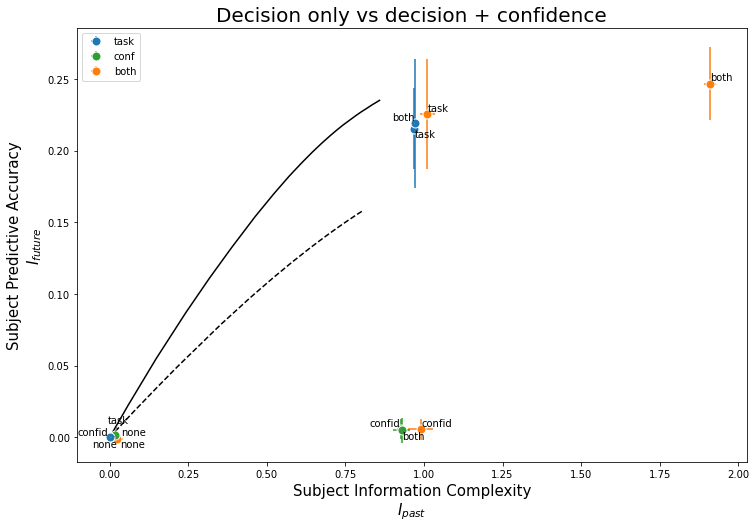

In [457]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
boot_data = boot_data_full#[boot_data_full['Subject'] == boot_data_full['Subject'].unique()[2]]

fig = plt.figure(1,(12,8))
ax = fig.add_subplot(111)
r,p=spearmanr(Ip_boot_df['mean'],If_boot_df['mean'])
ax.plot(ip_fullbound,if_fullbound,'-k')
ax.plot(ip_1backbound,if_1backbound,'--k')
texts = []
for index,row in boot_data.iterrows():
    ax.errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
             marker='o',markersize=9,mec='white',color=row['color'],ls='none', label = row['includes'])
    texts.append(ax.text(row['mean_ip'],row['mean_if'],row['label'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys(), loc = "upper left")
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
plt.show;

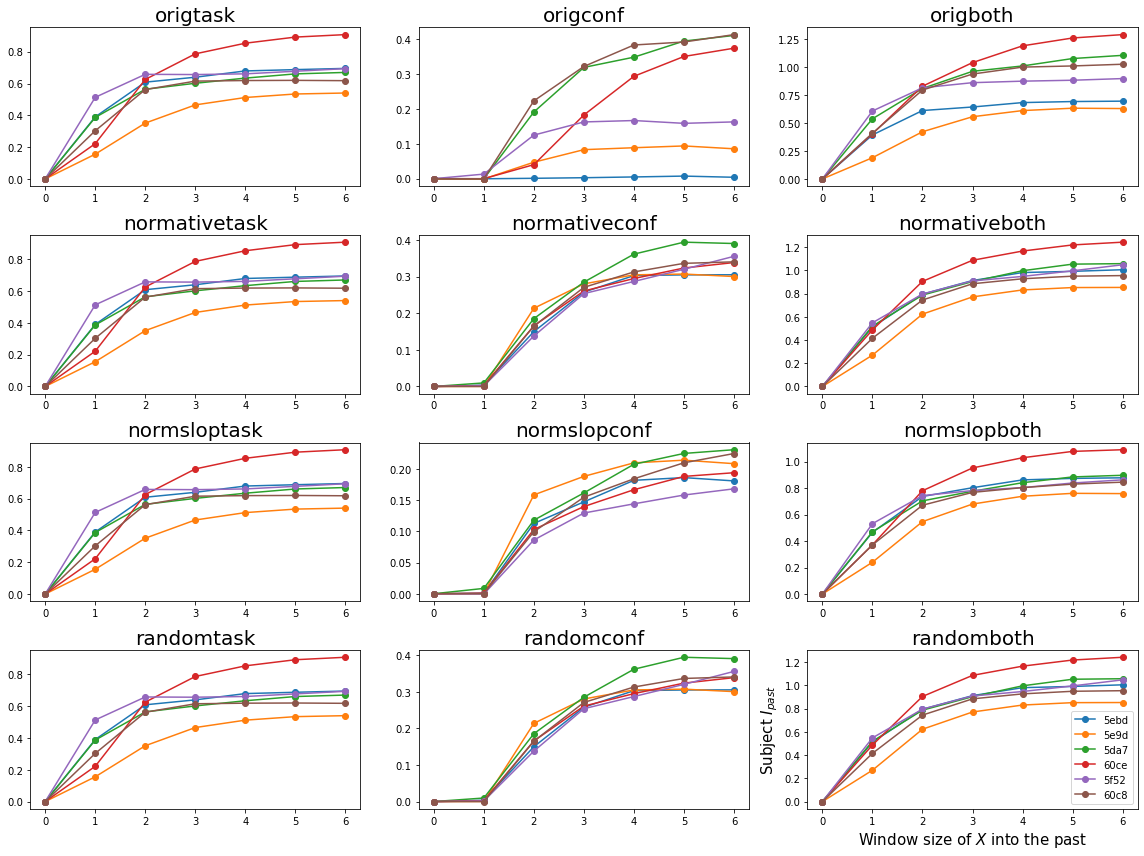

In [286]:
plt.figure(1,(16,12))
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        plt.subplot(4, 3, 3*i + j + 1)
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            plt.plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        plt.title(sim + includes,size=20)
        #plt.ylim([0,1])            

plt.xlabel('Window size of $X$ into the past',size=15)
plt.ylabel('Subject $I_{past}$',size=15)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();
